In [2]:
import torch
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

# Your first Neural Network
Before we get to convolutional neural networks, lets train a simple neural network.  First we need some sample data

In [2]:
x = np.linspace(0,10,100)
y = np.random.random(100)-.5+x

As you can probably imagine this is a linear relationship with a bit of noise.  You don't really need a neural network to model this, but we will anyway.  First lets visualize it.

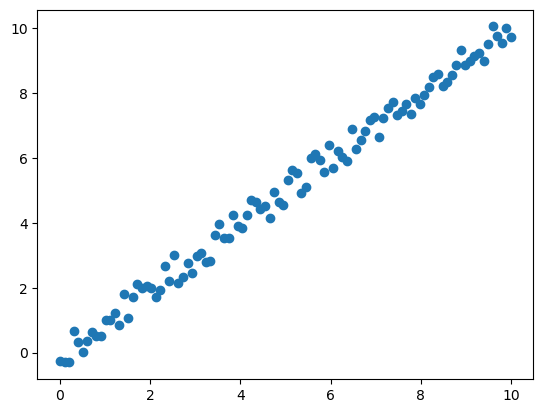

In [3]:
plt.plot(x, y, 'o')

If this were real data you collected, your first step would probably be to do a linear regression.  Lets do that.

In [4]:
slope, intercept, r, p, se = linregress(x,y)
modeled_y = slope*x+intercept

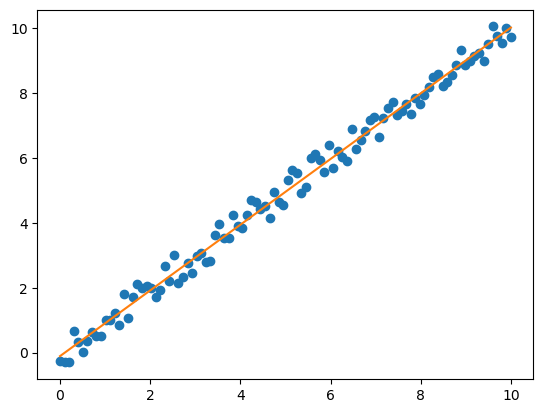

In [5]:
plt.plot(x, y, 'o')
plt.plot(x, modeled_y)

## PyTorch
Now we'll train a very simple neural network with PyTorch.  How simple?  This network will have one layer with one neuron.

In [6]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)
        
    def forward(self, x):
        return self.linear(x)

In [7]:
net = NeuralNet()

To train the network, we'll need a loss criterion, and an optimizer.

In [8]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Lastly we need to put our data into a tensor.  A tensor is like an array, but it's optimized to be used on GPUs.  It's the basic object that PyTorch works with. While we don't need any of the fancy tensor stuff for this example, we do need our data to be in tensors to use PyTorch.

In [9]:
data = torch.tensor(np.array([x,y]).T, dtype=torch.float32)

And finally we have our training loop.  We're going to train for 5 epochs, which means our network will see each point 5 times.  Now we also use the language of neural networks.  We have our inputs, the x values of our points, and the labels, or the thing we want to predict about it.  These are usually called labels because so often a neural network is being trained to do a classification task.  We use that language just to stay consistent with a lot of what's out there.

In [10]:
epochs = 10
# Here we keep track of some values to see how they change over time.
loss_values = []
weights = []
biases = []
for epoch in range(epochs):
    for input, label in data:
        # pull out the data and the label
        input = input.view(1,1)
        label = label.view(1,1)
        # zero the gradient of the optimizer
        optimizer.zero_grad()
        # pass the input through the network
        output = net(input)
        # calculate the loss for the networks predictions
        loss = criterion(output, label)
        # record the loss, and the network weight and bias
        loss_values.append(loss.detach())
        weights.append(net.linear.weight.item())
        biases.append(net.linear.bias.item())
        # backpropegate the loss
        loss.backward()
        # ??
        optimizer.step()


So what have we really trained in this neural network?  That's that linear layer.  But what *is* it really?

In [11]:
net.linear.__dict__

{'training': True,
 '_parameters': {'weight': Parameter containing:
  tensor([[1.0020]], requires_grad=True),
  'bias': Parameter containing:
  tensor([-0.0863], requires_grad=True)},
 '_buffers': {},
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': {},
 'in_features': 1,
 'out_features': 1}

You can see there's actually not that much in it, really just a weight tensor, and a bias tensor, the two paramters.  That's because this is a linear function
$\text{label}=\text{weight}*\text{input}+\text{bias}$
Look familar?  We can see how the weight and bias (and loss) changes over training.

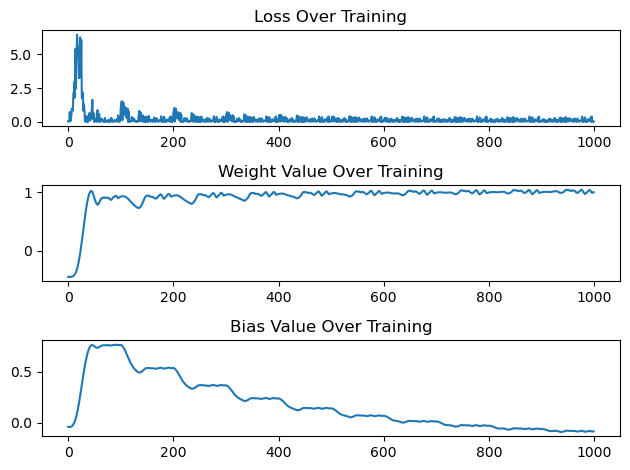

In [12]:
fig, axs = plt.subplots(3)
axs[0].plot(loss_values)
axs[1].plot(weights)
axs[2].plot(biases)
axs[0].set_title("Loss Over Training")
axs[1].set_title("Weight Value Over Training")
axs[2].set_title("Bias Value Over Training")
fig.tight_layout()

This network, is just a linear function that we've trained.  We can compare it 

In [13]:
w = net.linear.weight.item()
b = net.linear.bias.item()

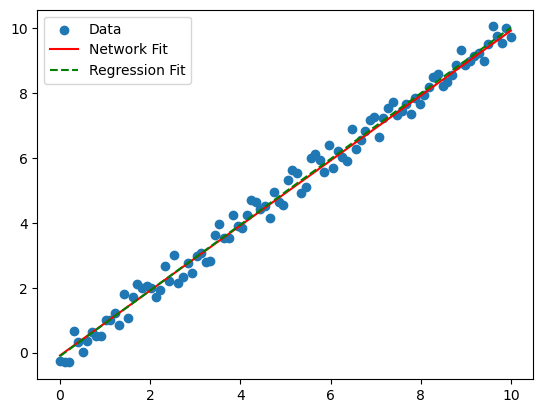

In [14]:
plt.scatter(x, y, label='Data')
plt.plot(x, w * x + b, color='red', label='Network Fit')
plt.plot(x, slope*x+intercept, '--', color='green', label="Regression Fit")
plt.legend()

So is that really a neural network?  Well yes!  A neural network is just a bunch of linear functions chained together. 
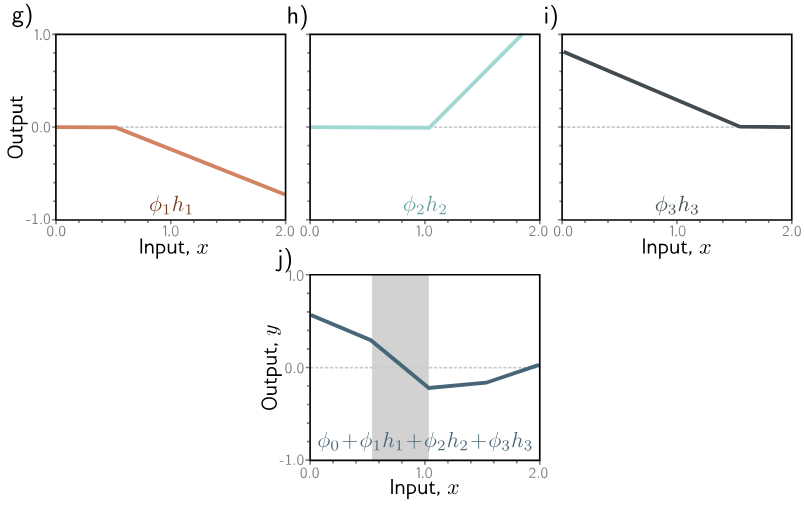 
[(Prince 2023)](https://udlbook.github.io/udlbook/)
You can see in the above figure that the components aren't quite linear.  That's because they have an activation function to add nonlinearity.  This example uses that ReLu activation which is really common, and just sets all values less than zero to zero.

# Convolutions
While traditionaly a neural network is constructed from linear functions and activation functions, you can also train together convolutions, which are great for spatial data.  With a convolution, you have a window of weights you slide across your input.  
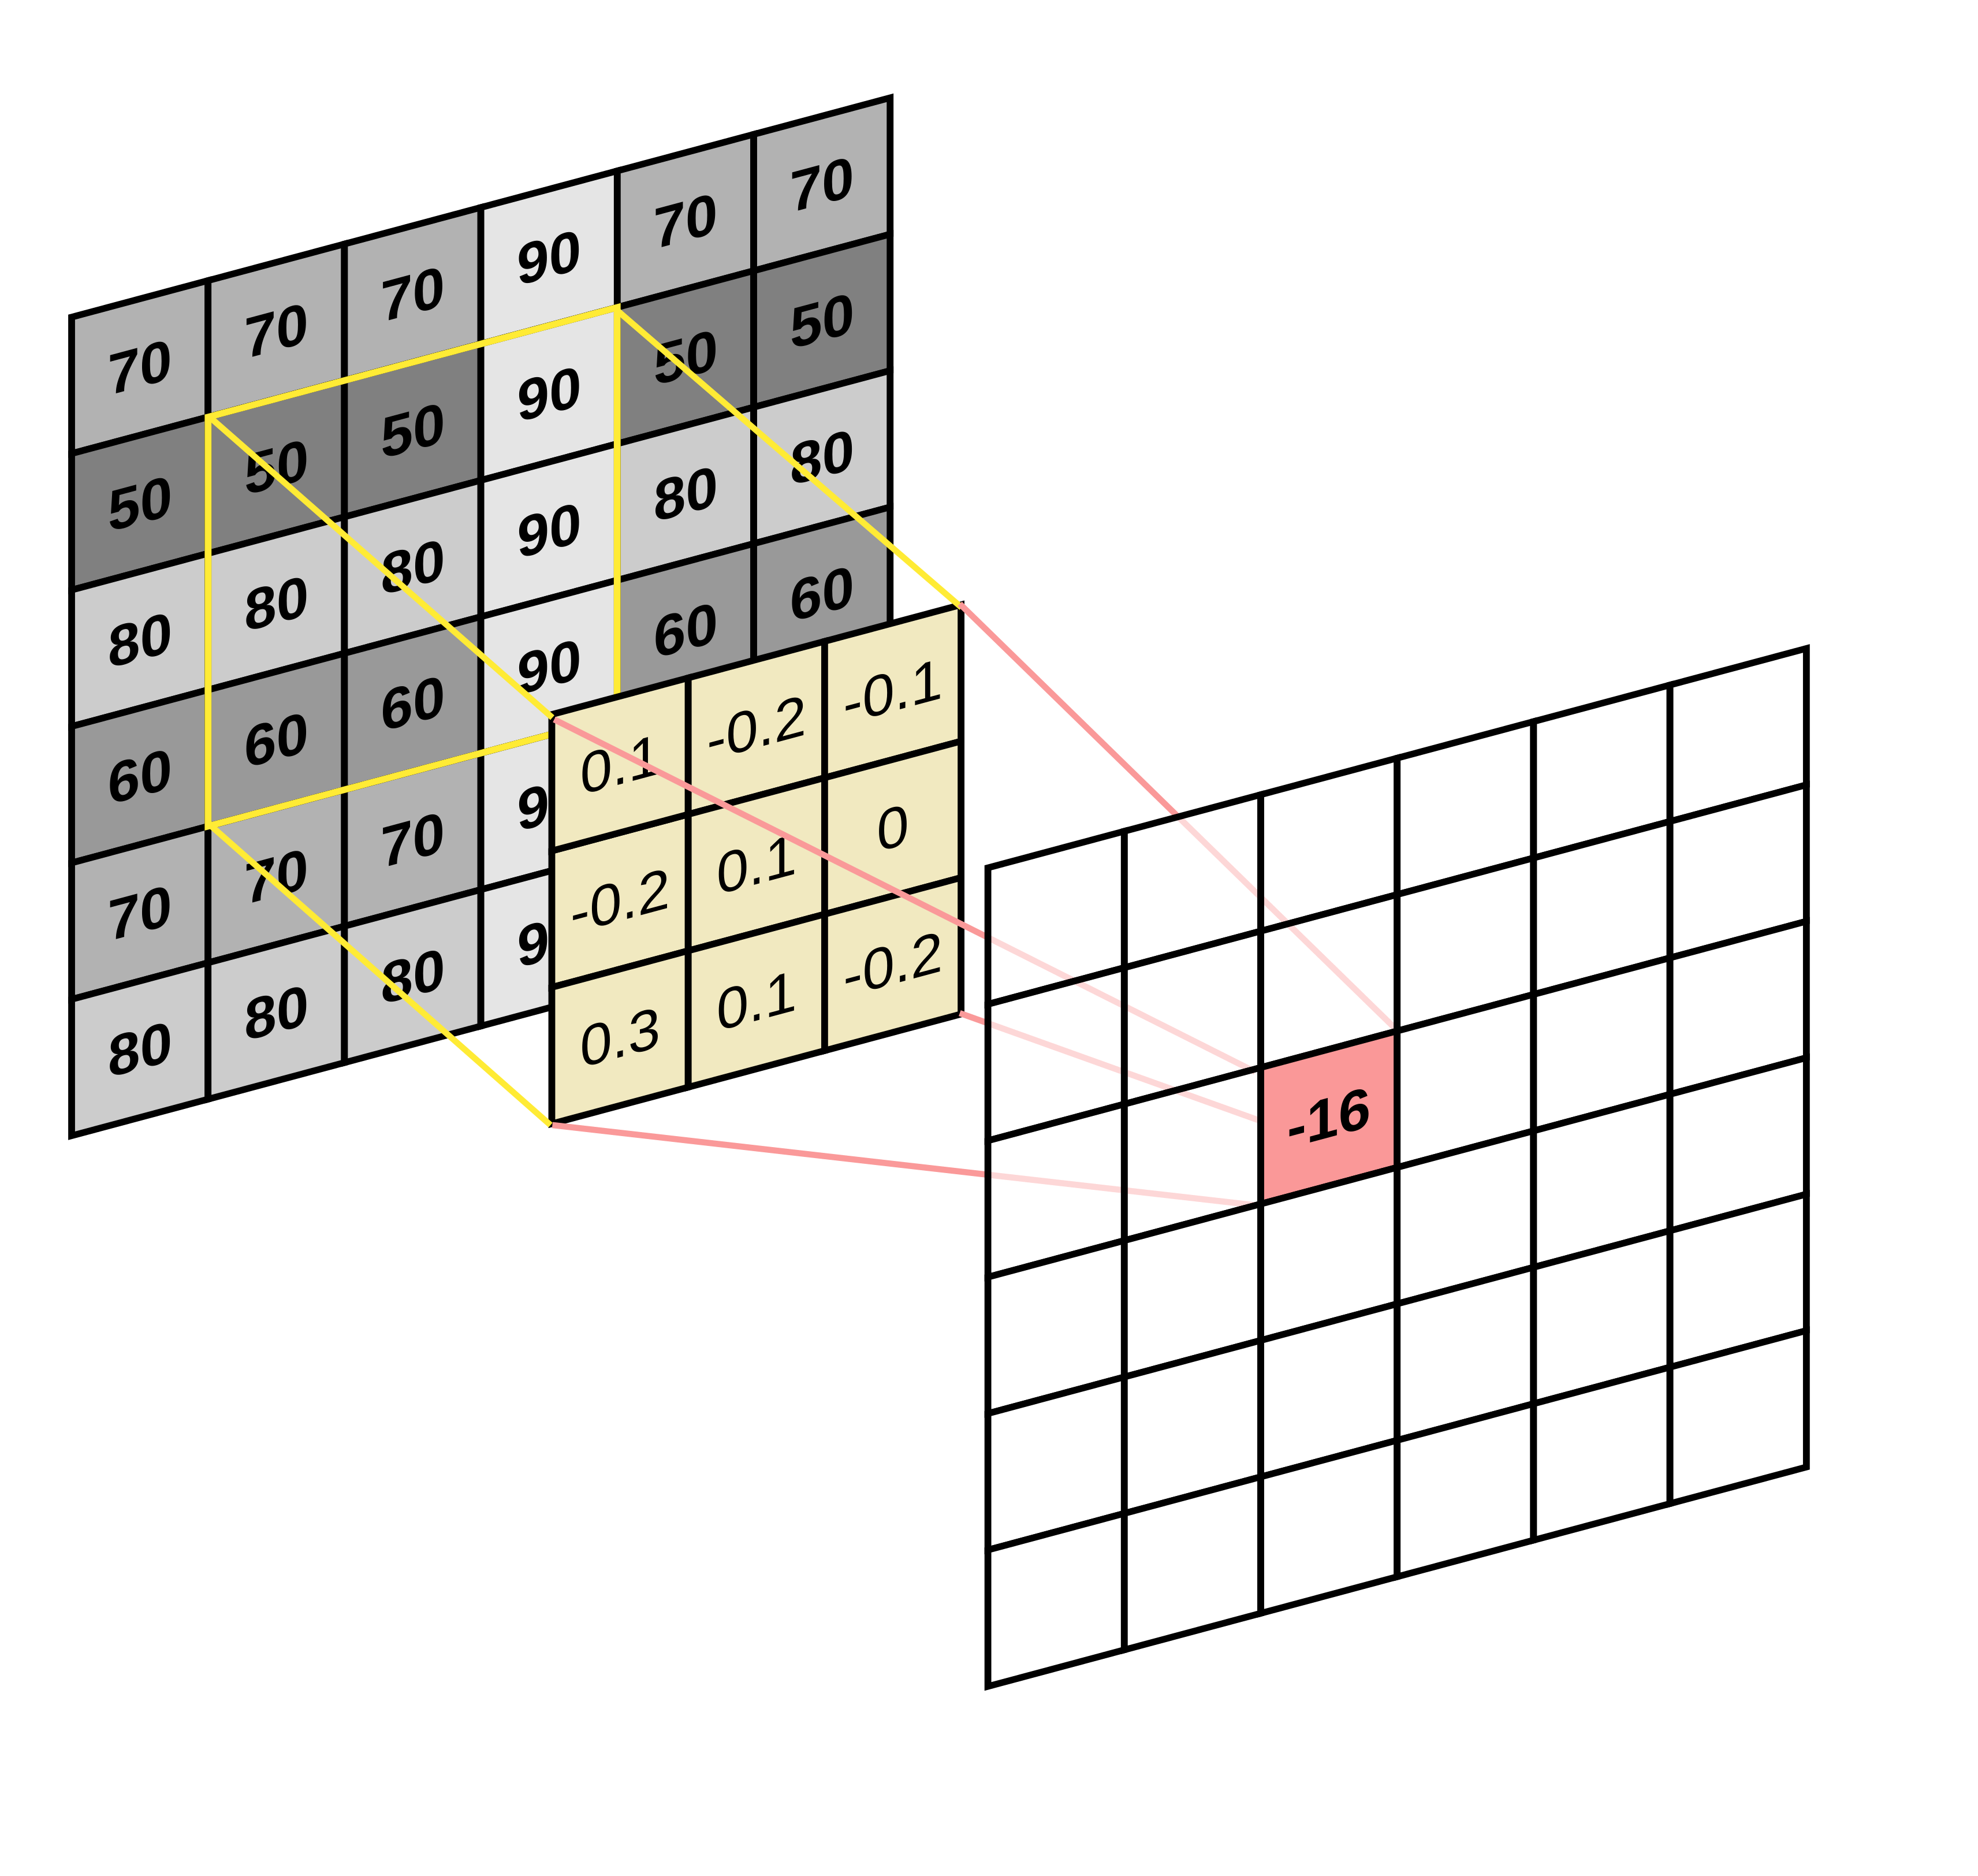
You then do a weighted sum with the portion of the input your convolution overlaps, using the weights from the convolution.  Lets load in some sample input to use with convolutions.

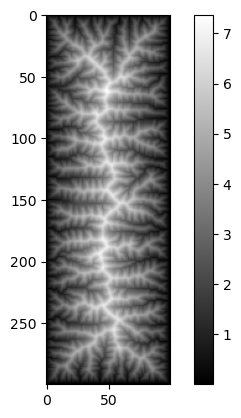

In [3]:
test_array = np.load('sample_landscape.npy')
plt.imshow(test_array, cmap="gray")
plt.colorbar()

To work with it in PyTorch, we'll need to make it into a tensor with an extra dimension (this will be explained later)

In [4]:
test_tensor = torch.unsqueeze(torch.tensor(test_array, dtype=torch.float32), dim=0)

Now we'll construct a custom convolution to see what it does when applied to the input.  The arguments given are 1,1,2 to say that this convolution takes in a 1 channel image, outputs a 1 channel image, and has a 2x2 window.  We'll also set some custom weights

In [5]:
conv = nn.Conv2d(1,1,3)
conv._parameters['weight']=torch.tensor([[[[-1,1,-1],
                                           [0,1,0],
                                           [-1,1,-1]]]], dtype=torch.float32)

In [6]:
output = conv(test_tensor)

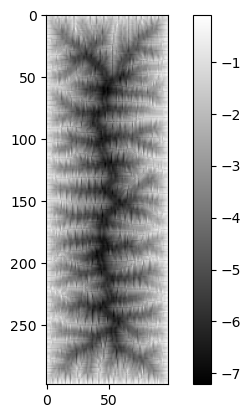

In [7]:
plt.imshow(torch.squeeze(output.detach()), cmap='gray')
plt.colorbar()

# Datasets and Dataloaders
A key part of PyTorch is datasets and dataloaders.  These are classes to help pass data into the neural network during training.  They help batch data for training on GPUs.  We'll make a simple dataset just for passing this test input and the convolution output again and again.

In [16]:
class SuperSimpleStupidDataset(Dataset):
    def __init__(self, length, input, outut):
        self.length=length
        self.input = input
        self.output = output

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.input.clone().detach(), self.output.clone().detach()

We will make a dataset and pass it into a dataloader.  Particularly we need to specifiy the batch size, which is the number of samples to be passed to the neural network at once.  A smaller batch means the network will update its weights more often, as it updates after every batch.  There are papers you can read about optimal batch size, but most people do between 64 and 256

In [17]:
dataset = SuperSimpleStupidDataset(2000,
                                   test_tensor.clone(),
                                   output.detach().clone())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)

Lets make a really simple one layer convolutional neural network and see if it can learn our convolution.

In [36]:
class ConvNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolution = nn.Conv2d(1, 1, 3)
        
    def forward(self, x):
        return self.convolution(x)

net = ConvNeuralNet()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
losses = []
weights = []
epochs = 50

for epoch in range(epochs):  # loop over the dataset multiple times

    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad(set_to_none=False)

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        weights.append(net.convolution.weight.detach().cpu().numpy().flatten())
        #for w in torch.flatten(net.convolution.weight.detach().clone()):
        #    weights.append(w)

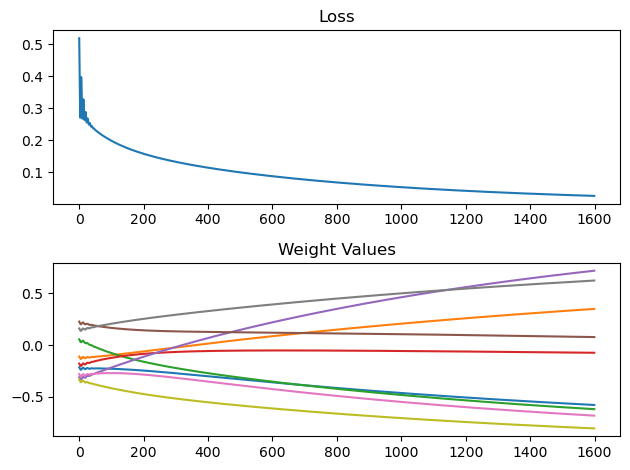

In [45]:
fig, axs=plt.subplots(2)
axs[0].plot(losses)
for i in range(9):
    axs[1].plot([w[i] for w in weights], label=f"Weight {i+1}")
#axs[1].legend()
axs[0].set_title("Loss")
axs[1].set_title("Weight Values")
fig.tight_layout()

In [38]:
pred = net(test_tensor)
plt.imshow(torch.squeeze(pred.detach()), cmap="gray")

It looks like it did a pretty good job, but what about the weights?

In [41]:
net.convolution.weight

Parameter containing:
tensor([[[[-0.5776,  0.3503, -0.6179],
          [-0.0733,  0.7192,  0.0783],
          [-0.6807,  0.6242, -0.8039]]]], requires_grad=True)

## A Typical CNN Unit
Above I breifly mentioned activation functions, and they are also used in CNNs as well.  In fact a typical CNN layer in a neural network will be followed by an activation function, and a pooling layer.  Pooling is used to reduce the resolution of the data to help speed up the network but keep the essential information there.  Like convolution pooling involves sweeping a window across the input, but instead using weights, you do something like take the maximum or the average value of the window.  Maximum is most common.  Returning to our network from earlier we have:

In [ ]:
class ConvNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolution = nn.Conv2d(1, 1, 3)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = (2,2), stride=(2,2))
        
    def forward(self, x):
        x = self.convolution(x)
        x = self.relu(x)
        return self.maxpool(x)

You'll see that series of three a lot in neural networks.  We'll go through some more simple architectures of neural networks to give you a sense of what you can do.  Unfortuatenly it's not feasible to train them over the course of this webinar.

### A Simple Network for Classification
This network goes from an input image to a vector with 10 elements, one for each class, representing something akin to likelihood.  You would usually use a different loss function, something like CrossEntropyLoss

In [ ]:
class ClassifierNet(nn.Module):
  def __init__(self):
    super().__init__()
    ## BLOCK CONV 1 ##
    self.conv1 = nn.Conv2d(1, 10, kernel_size=(3,3))
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size = (2,2), stride=(2,2))
    ## BLOCK CONV 2 ##
    self.conv2 = nn.Conv2d(10, 20, (5,5))
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size = (2,2), stride=(2,2))
    ## BLOCK CONV 3 ##
    self.conv3 = nn.Conv2d(20, 50, (15,15))
    self.relu3 = nn.ReLU()
    self.maxpool3 = nn.MaxPool2d(kernel_size = (2,2), stride=(2,2))
    ## LINEAR LAYERS ##
    self.fc1 = nn.Linear(4200, 800)
    self.relu3 = nn.ReLU()
    self.fc2 = nn.Linear(800, 100)
    self.relu4 = nn.ReLU()
    self.fc3 = nn.Linear(100,10)

  def forward(self, x):
    ## BLOCK CONV 1 ##
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)
    ## BLOCK CONV 2 ##
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)
    ## BLOCK CONV 3 ##
    x = self.conv3(x)
    x = self.relu3(x)
    x = self.maxpool3(x)
    ## FLATTEN FOR LINEAR ##
    x = torch.flatten(x, 1)
    ## LINEAR LAYERS ##
    x = self.fc1(x)
    x = self.relu3(x)
    x = self.fc2(x)
    x = self.relu4(x)
    x = self.fc3(x)
    return x

### A Single Number Network
You can also have the network spit out one number, if you are trying to infer a specific value

In [46]:
class NumberNet(nn.Module):
  def __init__(self):
    super().__init__()
    ## BLOCK CONV 1 ##
    self.conv1 = nn.Conv2d(1, 10, kernel_size=(3,3))
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size = (2,2), stride=(2,2))
    ## BLOCK CONV 2 ##
    self.conv2 = nn.Conv2d(10, 20, (5,5))
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size = (2,2), stride=(2,2))
    ## BLOCK CONV 3 ##
    self.conv3 = nn.Conv2d(20, 50, (15,15))
    self.relu3 = nn.ReLU()
    self.maxpool3 = nn.MaxPool2d(kernel_size = (2,2), stride=(2,2))
    ## LINEAR LAYERS ##
    self.fc1 = nn.Linear(4200, 800)
    self.relu3 = nn.ReLU()
    self.fc2 = nn.Linear(800, 100)
    self.relu4 = nn.ReLU()
    self.fc3 = nn.Linear(100,1)

  def forward(self, x):
    ## BLOCK CONV 1 ##
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)
    ## BLOCK CONV 2 ##
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)
    ## BLOCK CONV 3 ##
    x = self.conv3(x)
    x = self.relu3(x)
    x = self.maxpool3(x)
    ## FLATTEN FOR LINEAR ##
    x = torch.flatten(x, 1)
    ## LINEAR LAYERS ##
    x = self.fc1(x)
    x = self.relu3(x)
    x = self.fc2(x)
    x = self.relu4(x)
    x = self.fc3(x)
    return x

This network is simple but powerful, in my work it's been able to infer key model parameters from simple numerical models of landscape with high accuracy:

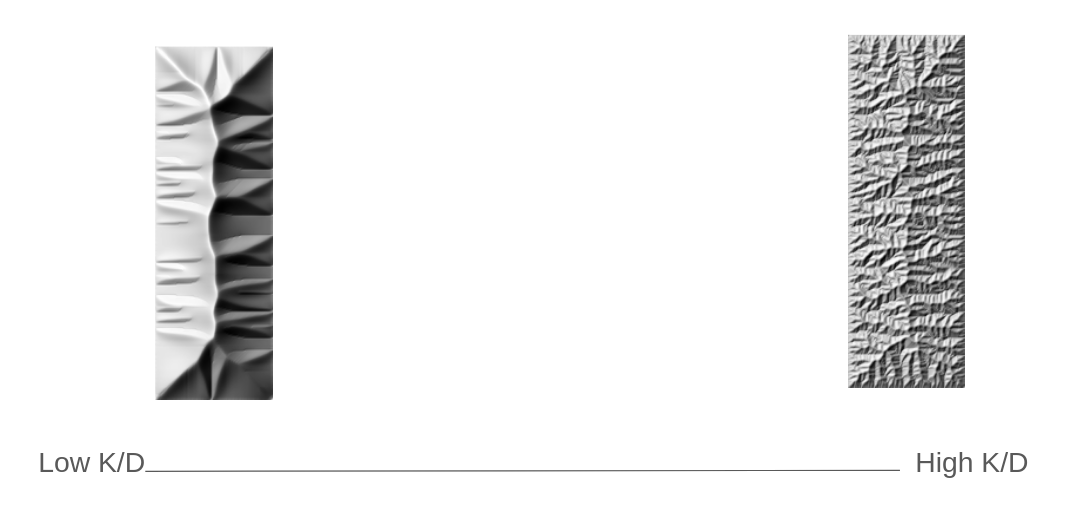
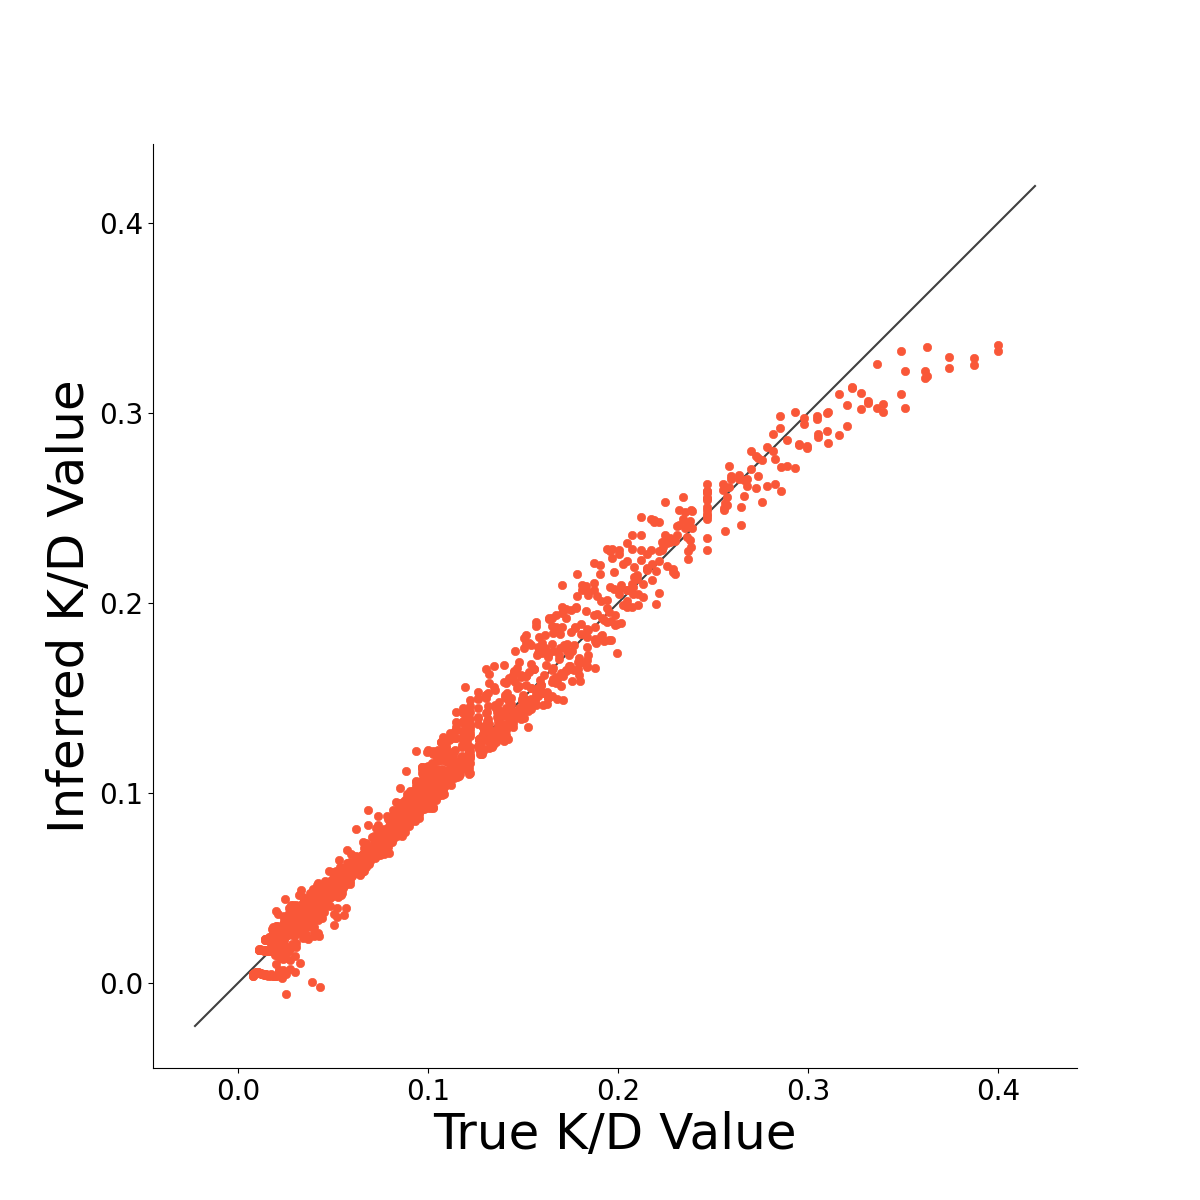

### Parallel Layers
You don't have to do everything in series either:

In [ ]:
class ClassifierNet(nn.Module):
  def __init__(self):
    super().__init__()
    ## BLOCK CONV 1 ##
    self.conv1 = nn.Conv2d(1, 10, kernel_size=(3,3))
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size = (2,2), stride=(2,2))
    ## BLOCK CONV 2 ##
    self.conv2 = nn.Conv2d(1, 10, (5,5))
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size = (2,2), stride=(2,2))
    ## BLOCK CONV 3 ##
    self.conv3 = nn.Conv2d(1, 10, (15,15))
    self.relu3 = nn.ReLU()
    self.maxpool3 = nn.MaxPool2d(kernel_size = (2,2), stride=(2,2))
    ## BLOCK CONV 4 ##
    self.conv4 = nn.Conv2d(30, 10, (7,7))
    self.relu4 = nn.ReLU()
    self.maxpool4 = nn.MaxPool2d(kernel_size = (2,2), stride=(2,2))
    ## LINEAR LAYERS ##
    self.fc1 = nn.Linear(4200, 800) # Number is wrong
    self.relu3 = nn.ReLU()
    self.fc2 = nn.Linear(800, 100)
    self.relu4 = nn.ReLU()
    self.fc3 = nn.Linear(100,10)

  def forward(self, x):
    ## BLOCK CONV 1 ##
    x1 = self.conv1(x)
    x1 = self.relu1(x1)
    x1 = self.maxpool1(x1)
    ## BLOCK CONV 2 ##
    x2 = self.conv2(x)
    x2 = self.relu2(x2)
    x2 = self.maxpool2(x2)
    ## BLOCK CONV 3 ##
    x3 = self.conv3(x)
    x3 = self.relu3(x3)
    x3 = self.maxpool3(x3)
    ## COMBINE CONVS ##
    x = torch.cat((x1,x2,x3), dim=1)
    ## BLOCK CONV 4 ##
    x = self.conv4(x)
    x = self.relu4(x)
    x = self.maxpool4(x)
    ## FLATTEN FOR LINEAR ##
    x = torch.flatten(x, 1)
    ## LINEAR LAYERS ##
    x = self.fc1(x)
    x = self.relu3(x)
    x = self.fc2(x)
    x = self.relu4(x)
    x = self.fc3(x)
    return x

# More on Dataloaders
Writing custom dataloaders ends up being important for spatial data.

In [48]:
label_query = "SELECT \"model_param.streampower.k\"/ \"model_param.diffuser.D\" FROM model_run_params"

def get_runs(database, filter_query = ""):
    connection = sqlite3.connect(database)
    cursor = connection.cursor()
    run_query = f"SELECT model_run_id FROM model_run_params {filter_query}"
    cursor.execute(run_query)
    return [r[0] for r in cursor.fetchall()]

class LandlabBatchdataset(Dataset):
    def __init__(self, database, dataset_dir, label_query, filter_query=None):
        self.img_db = database
        self.dataset_directory = dataset_dir
        self.connection = sqlite3.connect(database)
        self.cursor = connection.cursor()
        self.label_query = label_query
        if filter_query is not None:
            self.filter_query = filter_query
        else:
            self.filter_query = ""
        self.runs = get_runs(database, filter_query)
        self.transform = ToTensor()
        self.target_transform = ToTensor()


    def __len__(self):
        return len(self.runs)

    def __getitem__(self, idx):
        run_name = self.runs[idx]
        data_path = os.path.join(self.dataset_directory, f"{run_name}.npz")
        label_query = f"{self.label_query} WHERE model_run_id = \"{run_name}\""
        self.cursor.execute(label_query)
        label = self.cursor.fetchone()
        data_array = np.load(data_path)[run_name]
        data_array = data_array.astype(np.float32)[5:-5,5:-5]
        data_array = self.transform(data_array)
        label = torch.tensor(label, dtype=torch.float32)
        return data_array, label, run_name

In [49]:
class LandsatDataset:
    def __init__(self, bounds, collection, label_function, length=1000, pixels=225, scale=30, bands=['B2', 'B3', 'B4'], point_filter=None):
        self.bounds = bounds
        self.collection = collection
        self.label_function = label_function
        self.bands = bands
        self.bands_for_url = [{'id': band} for band in bands]
        self.point_filter = point_filter
        self.legnth=length
        self.pixels = pixels
        self.buffer_size = pixels*scale
        self.scale = scale
        lats = np.random.uniform(bounds[0][0], bounds[0][1], length)
        lons = np.random.uniform(bounds[1][0], bounds[1][1], length)
        self.points = [ee.Geometry.Point(lons[i], lats[i]) for i in range(length)]
        if point_filter is not None:
            self.points = point_filter(self.points)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.get_image_array(self.points[idx]), self.label_function(self.points[idx])
        

    def get_image_array(self, point):
        region = point.buffer(self.buffer_size).bounds()
        landsat = ee.ImageCollection(self.collection) \
                    .filterBounds(point) \
                    .sort('CLOUD_COVER') \
                    .first()
        clipped_image = landsat.clip(region)
        url = clipped_image.getDownloadURL({
            'scale': self.scale,
            'region': region,
            'bands': self.bands_for_url,
            'format': 'NPY'})
        darray = np.load(io.BytesIO(requests.get(url).content))            
        rows, columns = darray[self.bands[0]].shape
        top_offset = int((rows-self.pixels)/2)
        bottom_offset = rows-self.pixels-top_offset
        left_offset = int((columns-self.pixels)/2)
        right_offset = columns-self.pixels-left_offset
        bands = [darray[band_name][top_offset:-bottom_offset, right_offset:-left_offset]
                 for band_name in self.bands]
        for band in bands:
            if band.shape != (self.pixels, self.pixels):
                raise ValueError(f"Image returned has incorrect size ({band.shape}")
            if np.isinf(band).any():
                raise ValueError("Image still has NoData values")
        return np.stack(bands)#, axis=-1)
            

# TorchGeo
I haven't had the chance to play with this in much depth, but it is infastructure for working with spatial data, primarily sattelite based datasets.  It provides interfaces for working with that data, sometimes will download the data for you, and help you grab batches of imagary of specific sizes, orientations, etc.